In [1]:
import os
import boto3 
import pandas as pd

In [2]:
bucket_name = 'advanced-ml-project' # Add your bucket name
file_name = 'sessions.csv'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=file_name) # S3 uses key-value structure where key is your file name
df = pd.read_csv(obj['Body'])
df
df.head()

,app_id,session_id,start_timestamp,timezone,timezone_offset,previous_sessions_duration,user_created_timestamp,is_user_first_session,is_session,is_developer,...,country,region,city,latitude,longitude,locale,os_name,session_index,device_id,user_id_hash
0,4724682771660800,5558845121177764917,1542215364580,Asia/Manila,28800000.0,25837591,1538874289458,False,True,False,...,PH,00,makati,14.554729,121.024445,en_GB,Android OS,30,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,4724682771660800,2201961907282901522,1543712977293,Asia/Manila,28800000.0,35050130,1538874289458,False,True,False,...,PH,00,quezon city,14.676041,121.043701,en_GB,Android OS,47,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,4724682771660800,18781111175537580,1539215568666,Asia/Manila,28800000.0,11343848,1538874289458,False,True,False,...,PH,00,makati,14.554729,121.024445,en_GB,Android OS,10,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,4724682771660800,1477540082628742048,1540120743010,Asia/Manila,28800000.0,13499724,1538874289458,False,True,False,...,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,13,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,4724682771660800,8184875317380844086,1542671625528,Asia/Manila,28800000.0,32788010,1538874289458,False,True,False,...,PH,00,makati,14.554729,121.024445,en_GB,Android OS,41,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [3]:
len(df)

6239836

In [4]:
# filter out developer records and useless columns
df = df[df.is_developer!=1]
df = df.drop(['is_developer','app_id','is_wau','is_mau'], axis=1)
df = df.drop_duplicates(keep='first')

In [5]:
len(df)

6235752

In [6]:
pd.isnull(df).any()

session_id                    False
start_timestamp               False
timezone                       True
timezone_offset                True
previous_sessions_duration    False
user_created_timestamp        False
is_user_first_session         False
is_session                    False
country                        True
region                         True
city                           True
latitude                       True
longitude                      True
locale                         True
os_name                        True
session_index                 False
device_id                      True
user_id_hash                  False
dtype: bool

### Time Preprocess

In [7]:
# We need to fill na first
df.timezone_offset = df.timezone_offset.fillna(df['timezone_offset'].mean())

In [8]:
# change time into local time
df.start_timestamp = df.start_timestamp+df.timezone_offset
df.user_created_timestamp = df.user_created_timestamp+df.timezone_offset
df['start_time'] = pd.to_datetime(df.start_timestamp, unit = 'ms')
df['user_created_time'] =pd.to_datetime(df.user_created_timestamp, unit = 'ms')
df = df.drop(['start_timestamp','user_created_timestamp'], axis=1)

In [9]:
# extract date info
df['start_dow'] = df.start_time.dt.dayofweek
df['start_hour'] = df.start_time.dt.hour
df['start_date'] = df.start_time.dt.date
df['create_date'] = df.user_created_time.dt.date
df['create_session_time'] = df['start_date']-df['create_date']

In [10]:
df.create_session_time = df.create_session_time.apply(lambda x: int(str(x).split(' ')[0]))

In [11]:
df.head()

,session_id,timezone,timezone_offset,previous_sessions_duration,is_user_first_session,is_session,country,region,city,latitude,...,session_index,device_id,user_id_hash,start_time,user_created_time,start_dow,start_hour,start_date,create_date,create_session_time
0,5558845121177764917,Asia/Manila,28800000.0,25837591,False,True,PH,00,makati,14.554729,...,30,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,2018-11-15 01:09:24.580,2018-10-07 09:04:49.458,3,1,2018-11-15,2018-10-07,39
1,2201961907282901522,Asia/Manila,28800000.0,35050130,False,True,PH,00,quezon city,14.676041,...,47,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,2018-12-02 09:09:37.293,2018-10-07 09:04:49.458,6,9,2018-12-02,2018-10-07,56
2,18781111175537580,Asia/Manila,28800000.0,11343848,False,True,PH,00,makati,14.554729,...,10,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,2018-10-11 07:52:48.666,2018-10-07 09:04:49.458,3,7,2018-10-11,2018-10-07,4
3,1477540082628742048,Asia/Manila,28800000.0,13499724,False,True,PH,11,davao city,7.190708,...,13,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,2018-10-21 19:19:03.010,2018-10-07 09:04:49.458,6,19,2018-10-21,2018-10-07,14
4,8184875317380844086,Asia/Manila,28800000.0,32788010,False,True,PH,00,makati,14.554729,...,41,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,2018-11-20 07:53:45.528,2018-10-07 09:04:49.458,1,7,2018-11-20,2018-10-07,44


In [12]:
df = df.drop(['start_time', 'user_created_time'], axis=1)

### is_session

In [17]:
df.is_session.value_counts()

True     5165730
False    1070022
Name: is_session, dtype: int64

In [18]:
df[(df['session_id'].isin(list(df[df['is_session']==False].session_id)))].sort_values('session_id').head()

,session_id,timezone,timezone_offset,previous_sessions_duration,is_user_first_session,is_session,country,region,city,latitude,...,locale,os_name,session_index,device_id,user_id_hash,start_dow,start_hour,start_date,create_date,create_session_time
1588698,4760632880795,America/Chicago,-21600000.0,12353929,False,False,US,tx,san antonio,29.424122,...,en_US,Android OS,2,845d5958-260f-420d-b7be-8f3a44e03f43,7d77903651b8ccf92a81a0f0bc044e22a573c45eda49ab...,6,23,2018-11-11,2018-11-10,1
3736298,6306285814587,Africa/Ceuta,3600000.0,29610050,False,False,HR,19,dubrovnik,42.650661,...,en_US,Android OS,14,fce75647-d5d1-4282-a45f-d8ca82119017,38286df9de37b137378fbce09ae3d96854ed61e81e2fa5...,5,1,2018-11-17,2018-11-14,3
2188843,29736792627264,America/Chicago,-21600000.0,6676481,False,True,US,tx,austin,30.267153,...,en_US,Android OS,10,2e9a65ea-07fa-4665-87fc-34cd4539c05a,7c36f5187e730eb16833a264dbca791b431873e4df2c2a...,0,8,2018-11-12,2018-10-08,35
2188846,29736792627264,America/Chicago,-21600000.0,6676481,False,False,US,tx,austin,30.267153,...,en_US,Android OS,10,2e9a65ea-07fa-4665-87fc-34cd4539c05a,7c36f5187e730eb16833a264dbca791b431873e4df2c2a...,0,8,2018-11-12,2018-10-08,35
3477069,42438368918952,Asia/Manila,28800000.0,2572757,True,False,PH,00,quezon city,14.676041,...,en_US,Android OS,1,0c744d3f-1e24-4993-b532-6818146a7084,5149fa223ddf62f8874f2467b66b5c12e61cc26e0bc714...,1,12,2018-10-23,2018-10-22,1


From above table we could see like session_id = 29736792627264, if one `is_session=False`, if it also has `is_session=True` record, the two lines are same except `is_session` column. Thus, we should filter out this one of the repeated records.

In [13]:
# check the number of session which has offline info also has online info
len(df[(df['session_id'].isin(list(df[df['is_session']==False].session_id))) & (df['is_session']==True)])

237981

In [19]:
repeat_list = list(df[(df['session_id'].isin(list(df[df['is_session']==False].session_id))) & (df['is_session']==True)].session_id)

In [20]:
# filter the offline sessions which has both online/offline info
df = df.loc[~((df['session_id'].isin(repeat_list)) & (df['is_session']==False))].reset_index()

In [22]:
df = df.drop(['index'], axis=1)

In [ ]:
df.to_csv('feature_eng/sessions_new.csv')

### Split session by train_test users

In [24]:
file_name = 'sample_submission_2.csv'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=file_name) # S3 uses key-value structure where key is your file name
test_user = pd.read_csv(obj['Body'])

In [25]:
# test users are from submission file
test_list = list(test_user['user_id_hash'].unique())

In [26]:
print('The number of unique user in testset is', len(test_list))

The number of unique user in testset is 312568


In [27]:
df_test = df.loc[(df['user_id_hash'].isin(test_list))].reset_index()

In [29]:
print('The number of unique user in testset also in sessions is', len(df_test.user_id_hash.unique()))

The number of unique user in testset also in sessions is 312217


In [31]:
df_test = df_test.drop(['index'], axis=1)

In [54]:
# get the session info for test users
df_test.to_csv('feature_eng/sessions_test.csv')

In [55]:
df.head()

,session_id,timezone,timezone_offset,previous_sessions_duration,is_user_first_session,is_session,country,region,city,latitude,...,locale,os_name,session_index,device_id,user_id_hash,start_dow,start_hour,start_date,create_date,create_session_time
0,5558845121177764917,Asia/Manila,28800000.0,25837591,False,True,PH,00,makati,14.554729,...,en_GB,Android OS,30,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,3,1,2018-11-15,2018-10-07,39
1,2201961907282901522,Asia/Manila,28800000.0,35050130,False,True,PH,00,quezon city,14.676041,...,en_GB,Android OS,47,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,6,9,2018-12-02,2018-10-07,56
2,18781111175537580,Asia/Manila,28800000.0,11343848,False,True,PH,00,makati,14.554729,...,en_GB,Android OS,10,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,3,7,2018-10-11,2018-10-07,4
3,1477540082628742048,Asia/Manila,28800000.0,13499724,False,True,PH,11,davao city,7.190708,...,en_GB,Android OS,13,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,6,19,2018-10-21,2018-10-07,14
4,8184875317380844086,Asia/Manila,28800000.0,32788010,False,True,PH,00,makati,14.554729,...,en_GB,Android OS,41,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...,1,7,2018-11-20,2018-10-07,44


Because train user label are built since 12/1/2018, we only could use sessions information before that time.

In [56]:
import datetime
date_before = datetime.date(2018, 12, 1)
df_train = df[df.start_date<date_before]

In [57]:
df_train = df_train.reset_index()
df_train = df_train.drop(['index'], axis=1)

In [59]:
# get the session info for train users
df_train.to_csv('feature_eng/sessions_train.csv')

### EDA

In [32]:
pd.isnull(df).any()

session_id                    False
timezone                       True
timezone_offset               False
previous_sessions_duration    False
is_user_first_session         False
is_session                    False
country                        True
region                         True
city                           True
latitude                       True
longitude                      True
locale                         True
os_name                        True
session_index                 False
device_id                      True
user_id_hash                  False
start_dow                     False
start_hour                    False
start_date                    False
create_date                   False
create_session_time           False
dtype: bool

Have a look at the features in `sessions` dataset.

In [40]:
df.is_user_first_session.value_counts()

False    5167409
True      830360
Name: is_user_first_session, dtype: int64

In [70]:
print('The percentage of first session in all sessions is' , round(5167409/(830360+5167409),2))

The percentage of first session in all sessions is  0.86


In [42]:
df.is_session.value_counts()

True     5165730
False     832039
Name: is_session, dtype: int64

In [71]:
print('The percentage of online session in all sessions is' , round(5165730/(832039+5165730),2))

The percentage of online session in all sessions is 0.86


In [60]:
country = df.country.value_counts().nlargest(10)

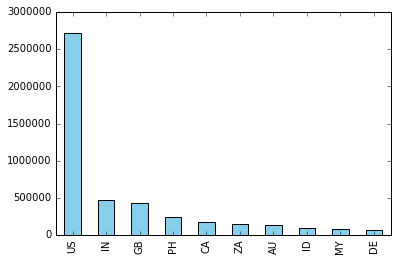

In [62]:
country .plot.bar(color = 'SkyBlue')

Most users are from US.

In [78]:
os = df.os_name.value_counts()

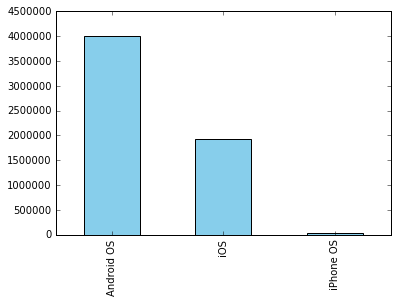

In [79]:
os.plot.bar(color = 'SkyBlue')